# Prática 1

## Inferência Bayesiana

***Estatística para Ciência de Dados***

por **Cibele Russo** (ICMC/USP - São Carlos SP)

**MBA em Ciências de Dados**






### Exercício:

Na aplicação de dados bancários que vimos na Aula 1 (clientes do banco), considere diferentes tamanhos de amostra e diferentes prioris e veja como interferem na posteriori. 

Além disso, altere os parâmetros da distribuição a priori (chamados **hiperparâmetros**) e verifique os efeitos na distribuição a posteriori.

Considere, por exemplo, uma distribuição a priori beta para a proporção p, com diferentes hiperparâmetros. Compare os resultados com os obtidos com uma distribuição a priori uniforme para p.

### Exemplo de priori conjugada beta-Bernoulli

Ver https://towardsdatascience.com/conjugate-prior-explained-75957dc80bfb



No exemplo do banco, se considerarmos que


- $X=\left\{ \begin{array}{lll} 1, &\mbox{se o cliente é classificado como inadimplente,} \\ 0, &\mbox{caso contrário.} \end{array}\right.$


- $X \sim Bernoulli(p)$


- Verossimilhança:

Para $n$ suficientemente grande, pelo TLC sabemos que a distribuição amostral de $\bar{X}$ se aproxima da normal $$\bar{X} \sim N\left(p, \displaystyle{\frac{p(1-p)}{n}}\right)$$


Além disso, $Y = \sum_{i=1}^{n} X_i \sim binomial(np, np(1-p))$. 





In [1]:
import pandas as pd

# Indique o seu diretório se necessário
#pkgdir = '/hdd/MBA/ECD/Data'
#dados = pd.read_csv(f'{pkgdir}/dados_banco.csv', index_col=0)


# Dados banco - Leitura dos dados
dados = pd.read_csv('dados_banco.csv', index_col=0)

dados.head()

,Cliente,Sexo,Idade,Empresa,Salario,Saldo_cc,Saldo_poupança,Saldo_investimento,Devedor_cartao,Inadimplente
75928,75928,M,32,Privada,5719.00,933.79,0.0,0.0,6023.68,0
52921,52921,F,28,Privada,5064.00,628.37,0.0,0.0,1578.24,0
8387,8387,F,24,Autônomo,4739.00,889.18,0.0,0.0,2578.70,0
54522,54522,M,30,Pública,5215.00,1141.47,0.0,0.0,4348.96,0
45397,45397,M,30,Autônomo,5215.56,520.70,0.0,0.0,1516.78,1


**Considere diferentes tamanhos de amostra. Como interferem na posteriori?** 

In [2]:
# Vamos trabalhar com uma amostra
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt
import random

a = 2
b = 8

amostra = dados.sample(n=500, replace=False, random_state=10)

n = len(amostra)
k = amostra['Inadimplente'].sum()
posteriori = beta(a + k, n - k + b) 

k/n

0.268

**Considere diferentes tipos de priori, por exemplo beta ou uniforme. Como interferem na posteriori?**

## Priori 1 - beta

- Priori: $p \sim beta(2, 8)$


- Posteriori: $p|k \sim beta(k+a, n-k+b)$

onde $k$ é o número de sucessos observados na amostra.


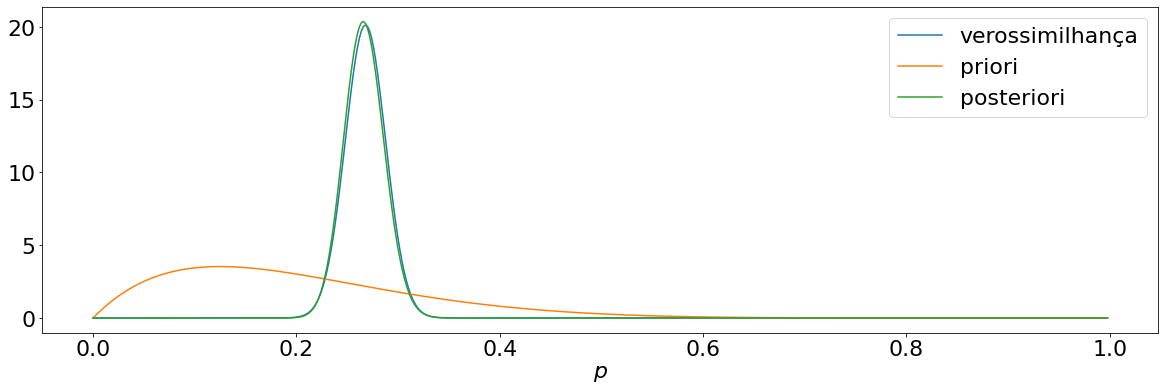

In [3]:
from scipy.stats import norm

# Eixo x entre 0 e 1 de .002 em .002.
x_axis = np.arange(0, 1, 0.002)

# Plota as densidades da beta para cada conjunto de parâmetros
plt.figure(figsize=(20,6))
    
prior = beta(a, b)

p_chapeu = amostra['Inadimplente'].mean()
dp = np.sqrt(p_chapeu*(1-p_chapeu)/n)

media = p_chapeu
dp = np.sqrt(media*(1-media)/n)

plt.s = 0
plt.rcParams.update({'font.size': 22})

plt.plot(x_axis, norm.pdf(x_axis, media, dp), label='verossimilhança')
plt.plot(x_axis, prior.pdf(x_axis), label='priori')
plt.plot(x_axis, posteriori.pdf(x_axis), label='posteriori')    
plt.xlabel(r'$p$')
plt.legend()


In [4]:
# Estimador bayesiano EAP (Esperança a posteriori)
print('Média: %.2f' % posteriori.mean())


# E para calcular um intervalo de credibilidade, decidimos uma probabilidade 
# Por exemplo 95% para a credibilidade
# Uma maneira seria definir que 2,5% de cada cauda como os limites do intervalo (chamado intervalo simétrico)
# Este método é válido quando a posteriori se aproxima de uma distribuição simétrica, pois nesse caso tende a gerar o intervalo com menor amplitude
# A seguir, apresentamos outra solução com um intervalo de credibilidade de menor amplitude.

LI = posteriori.ppf(.025)
LS = posteriori.ppf(.975)
print("Intervalo com 95% de credibilidade: {:.3f}, {:.3f})".format(LI,LS))


Média: 0.27
Intervalo com 95% de credibilidade: 0.229, 0.306)


## Exemplos




In [5]:
#!pip install pymc3==3.11.1


In [6]:
#!pip install arviz==0.11.2

In [7]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt


In [8]:
!pip show pymc3

Name: pymc3
Version: 3.11.4
Summary: Probabilistic Programming in Python: Bayesian Modeling and Probabilistic Machine Learning with Theano
Home-page: http://github.com/pymc-devs/pymc3
Author: None
Author-email: None
License: Apache License, Version 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: pandas, fastprogress, dill, scipy, theano-pymc, arviz, numpy, typing-extensions, semver, patsy, cachetools
Required-by: 


In [9]:
!pip show arviz

Name: arviz
Version: 0.12.0
Summary: Exploratory analysis of Bayesian models
Home-page: http://github.com/arviz-devs/arviz
Author: ArviZ Developers
Author-email: None
License: Apache-2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: packaging, pandas, setuptools, matplotlib, netcdf4, numpy, xarray, scipy, typing-extensions
Required-by: pymc3


## Modelo beta-Bernoulli: clientes do banco 

Com amostra de 500 observações, considere, por exemplo, priori beta (10,5). Compare com os resultados obtidos em aula.

In [10]:
with pm.Model() as model:
    p = pm.Beta("p", 10, 5)
    obs = pm.distributions.discrete.Bernoulli("obs", p, observed=amostra['Inadimplente'])

    idata = pm.sample(2000, tune=1500, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p]


Sampling 2 chains for 1_500 tune and 2_000 draw iterations (3_000 + 4_000 draws total) took 4 seconds.


In [11]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.28,0.02,0.242,0.316,0.0,0.0,1762.0,2695.0,1.0


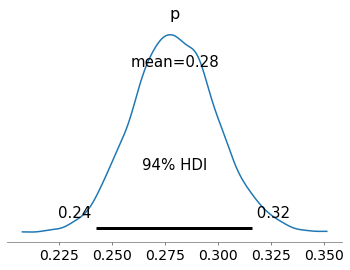

In [12]:
az.plot_posterior(idata);


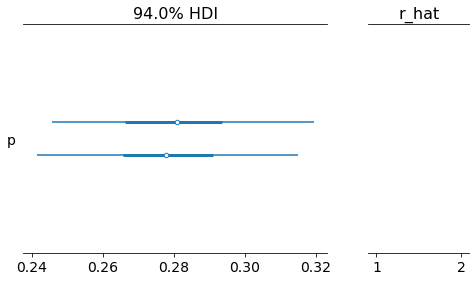

In [13]:
az.plot_forest(idata, r_hat=True);

### Análise de resultados

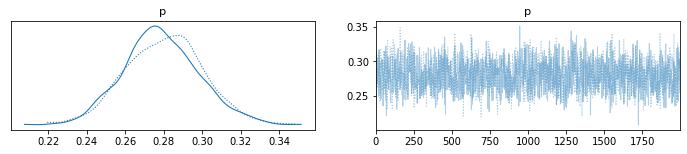

In [14]:
az.plot_trace(idata);


In [15]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.28,0.02,0.242,0.316,0.0,0.0,1762.0,2695.0,1.0


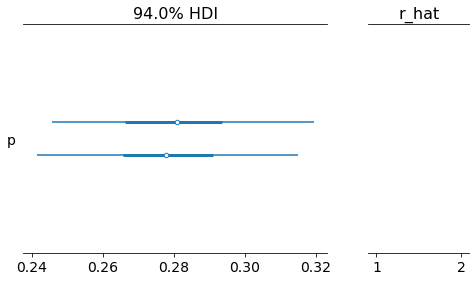

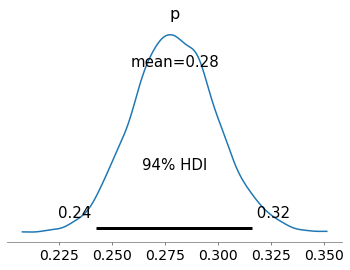

In [16]:
az.plot_forest(idata, r_hat=True);

az.plot_posterior(idata);


## Priori uniforme

Considere agora, por exemplo, priori uniforme para a proporção p. Como interfere na posteriori?

**Refaça as análises com diferentes tamanhos de amostra, por exemplo 100 ou 10000.**

In [17]:
with pm.Model() as model:
    p = pm.Uniform("p")
    obs = pm.distributions.discrete.Bernoulli("obs", p, observed=amostra['Inadimplente'])

    idata = pm.sample(2000, tune=1500, return_inferencedata=True)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p]


Sampling 2 chains for 1_500 tune and 2_000 draw iterations (3_000 + 4_000 draws total) took 6 seconds.


In [18]:
az.summary(idata)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.269,0.02,0.232,0.304,0.0,0.0,1874.0,2862.0,1.0


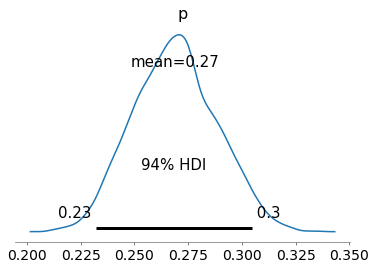

In [19]:
az.plot_posterior(idata);


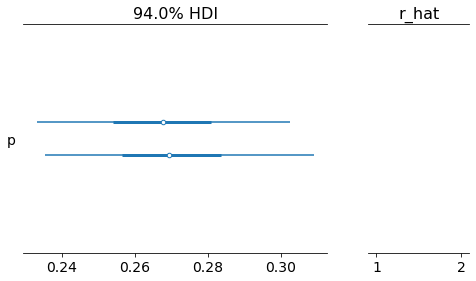

In [20]:
az.plot_forest(idata, r_hat=True);


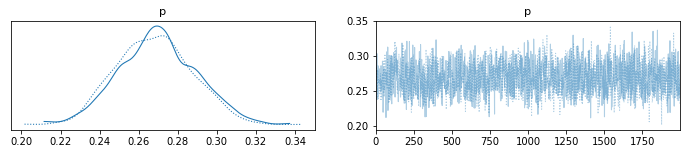

In [21]:

### Análise de resultados

az.plot_trace(idata);



In [22]:

az.summary(idata)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.269,0.02,0.232,0.304,0.0,0.0,1874.0,2862.0,1.0


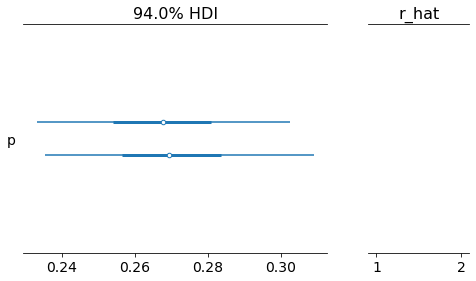

In [23]:

az.plot_forest(idata, r_hat=True);


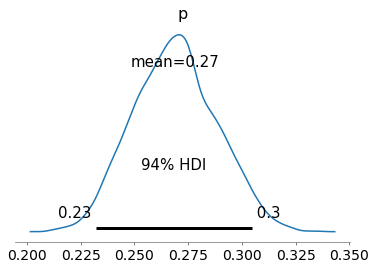

In [24]:

az.plot_posterior(idata);
